In [1]:
!pip install nltk

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
import re

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

In [7]:
# For sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [8]:

# For reproducibility
RANDOM_STATE = 42


#### 1. Data Exploration and Preprocessing

In [9]:
data=pd.read_csv("blogs.csv")
data.head()

,Data,Labels
0,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism
1,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,alt.atheism
2,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,alt.atheism
3,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism
4,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...,alt.atheism


In [10]:
data.columns

Index(['Data', 'Labels'], dtype='object')

In [12]:
data.shape

(2000, 2)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    2000 non-null   object
 1   Labels  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [14]:
data.isnull().sum()

Data      0
Labels    0
dtype: int64

In [16]:
# Text length distribution (basic insight)
data['text_length'] = data['Data'].apply(lambda x: len(str(x).split()))
print("\nText length stats (in words):")
print(data['text_length'].describe())


Text length stats (in words):
count     2000.000000
mean       314.166000
std        539.210333
min         31.000000
25%        127.000000
50%        194.000000
75%        319.000000
max      10384.000000
Name: text_length, dtype: float64


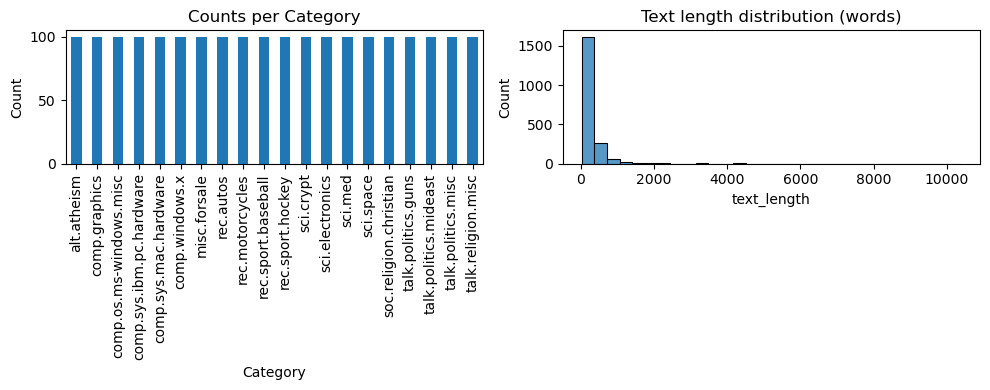

In [17]:
# Plot label distribution and text length histogram
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
data['Labels'].value_counts().plot(kind='bar')
plt.title('Counts per Category')
plt.xlabel('Category')
plt.ylabel('Count')

plt.subplot(1,2,2)
sns.histplot(data['text_length'], bins=30)
plt.title('Text length distribution (words)')
plt.tight_layout()
plt.show()

In [21]:
# First, download the required NLTK resources
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')  # For tokenization
nltk.download('wordnet')  # For lemmatization

# Now import the required modules
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# 3. Preprocessing helpers ---
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_text_basic(text):
    """
    Basic text cleaning:
    - Lowercase
    - Remove URLs
    - Remove HTML tags
    - Remove non-alphabetic characters (keep spaces)
    - Strip extra spaces
    """
    text = str(text)
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # Keep only letters and spaces
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_and_normalize(text, do_stem=False, do_lemmatize=True, remove_stopwords=True):
    """
    Tokenize text and optionally lemmatize/stem and remove stopwords.
    Returns joined tokens string (for vectorizers that expect text).
    """
    text = clean_text_basic(text)
    tokens = nltk.word_tokenize(text)
    processed_tokens = []
    for t in tokens:
        if remove_stopwords and t in stop_words:
            continue
        if do_lemmatize:
            t = lemmatizer.lemmatize(t)
        if do_stem:
            t = stemmer.stem(t)
        if len(t) > 1:
            processed_tokens.append(t)
    return " ".join(processed_tokens)

# Add a cleaned column (we'll use TF-IDF so return strings)
print("\nCleaning a few sample texts...")
data['cleaned'] = data['Data'].apply(lambda x: tokenize_and_normalize(x))
print(data[['Data','cleaned']].head(3))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Cleaning a few sample texts...
                                                Data  \
0  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...   
1  Newsgroups: alt.atheism\nPath: cantaloupe.srv....   
2  Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...   

                                             cleaned  
0  path cantaloupe srv cmu edu magnesium club cc ...  
1  newsgroups alt atheism path cantaloupe srv cmu...  
2  path cantaloupe srv cmu edu da news harvard ed...  


In [24]:
#  Feature extraction using TF-IDF ---
# We'll use sklearn TfidfVectorizer. We already preprocessed tokens (lemmatized + stopwords removed),
# but TfidfVectorizer can still perform ngram extraction etc. We'll set min_df to avoid super-rare tokens.
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=2)

# Encode labels
label_encoder = LabelEncoder()
data['label_encoded'] = label_encoder.fit_transform(data['Labels'])
print("\nLabel classes:", label_encoder.classes_)


Label classes: ['alt.atheism' 'comp.graphics' 'comp.os.ms-windows.misc'
 'comp.sys.ibm.pc.hardware' 'comp.sys.mac.hardware' 'comp.windows.x'
 'misc.forsale' 'rec.autos' 'rec.motorcycles' 'rec.sport.baseball'
 'rec.sport.hockey' 'sci.crypt' 'sci.electronics' 'sci.med' 'sci.space'
 'soc.religion.christian' 'talk.politics.guns' 'talk.politics.mideast'
 'talk.politics.misc' 'talk.religion.misc']


In [25]:
#  Train-test split ---
X = data['cleaned']
y = data['label_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)
print(f"\nTrain size: {len(X_train)}, Test size: {len(X_test)}")

# Fit TF-IDF on training data and transform both train/test
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


Train size: 1600, Test size: 400


In [26]:
# ---  Train Naive Bayes (MultinomialNB) ---
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

# Predictions
y_pred = nb.predict(X_test_tfidf)


Accuracy: 0.8925

Classification report (precision, recall, f1 by class):
                          precision    recall  f1-score   support

             alt.atheism       1.00      0.65      0.79        20
           comp.graphics       0.82      0.90      0.86        20
 comp.os.ms-windows.misc       0.91      1.00      0.95        20
comp.sys.ibm.pc.hardware       0.80      1.00      0.89        20
   comp.sys.mac.hardware       1.00      0.95      0.97        20
          comp.windows.x       0.94      0.75      0.83        20
            misc.forsale       0.91      1.00      0.95        20
               rec.autos       0.83      1.00      0.91        20
         rec.motorcycles       1.00      0.85      0.92        20
      rec.sport.baseball       0.95      1.00      0.98        20
        rec.sport.hockey       1.00      1.00      1.00        20
               sci.crypt       0.95      1.00      0.98        20
         sci.electronics       1.00      0.70      0.82        20


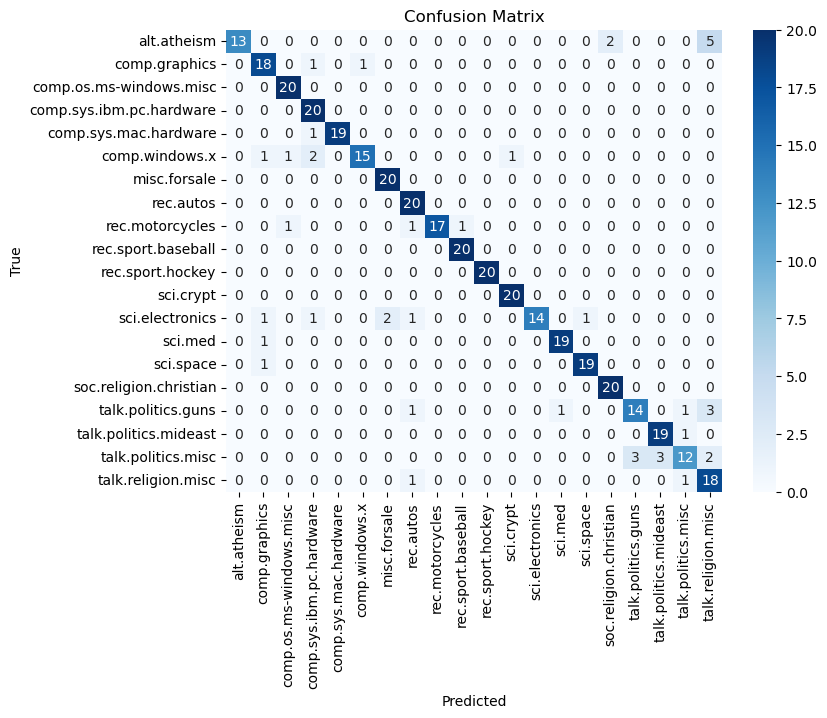


Top 10 tokens for class 'alt.atheism':
edu, atheism, alt atheism, alt, com, newsgroups alt, atheist, keith, objective, cmu

Top 10 tokens for class 'comp.graphics':
graphic, edu, comp graphic, comp, cmu, cmu edu, graphic subject, newsgroups comp, file, graphic path

Top 10 tokens for class 'comp.os.ms-windows.misc':
window, comp window, edu, comp, window misc, misc, file, do, nt, cmu

Top 10 tokens for class 'comp.sys.ibm.pc.hardware':
pc, edu, ibm, ibm pc, sys ibm, pc hardware, hardware, comp sys, sys, comp

Top 10 tokens for class 'comp.sys.mac.hardware':
mac, edu, sys mac, mac hardware, sys, comp sys, hardware, comp, cmu, cmu edu

Top 10 tokens for class 'comp.windows.x':
window, comp window, edu, comp, motif, newsgroups comp, cmu edu, cmu, window path, com

Top 10 tokens for class 'misc.forsale':
forsale, edu, misc forsale, misc, newsgroups misc, sale, cmu, cmu edu, forsale subject, forsale path

Top 10 tokens for class 'rec.autos':
auto, rec auto, edu, car, rec, newsgroups rec, c

In [27]:
# --- . Evaluation ---
acc = accuracy_score(y_test, y_pred)
print("\nAccuracy:", acc)

print("\nClassification report (precision, recall, f1 by class):")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Show top features per class (optional, for interpretability)
def show_top_n_for_class(class_index, nb_model, tfidf_vectorizer, label_encoder, n=15):
    """
    Show top n tokens that are most indicative for a given class.
    For MultinomialNB we can use log probabilities.
    """
    feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
    class_log_prob = nb_model.feature_log_prob_[class_index]  # log prob for features in class
    top_n = np.argsort(class_log_prob)[-n:][::-1]
    print(f"\nTop {n} tokens for class '{label_encoder.classes_[class_index]}':")
    print(", ".join(feature_names[top_n]))

# Example: show for each class
for i in range(len(label_encoder.classes_)):
    show_top_n_for_class(i, nb, tfidf, label_encoder, n=10)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...



Computing sentiment labels for each blog post...

Sentiment distribution overall:
sentiment
positive    1334
negative     631
neutral       35
Name: count, dtype: int64
sentiment
positive    0.6670
negative    0.3155
neutral     0.0175
Name: proportion, dtype: float64

Sentiment distribution by category (proportions):
sentiment                 negative  neutral  positive
Labels                                               
alt.atheism                   0.42     0.01      0.57
comp.graphics                 0.13     0.04      0.83
comp.os.ms-windows.misc       0.24     0.02      0.74
comp.sys.ibm.pc.hardware      0.21     0.00      0.79
comp.sys.mac.hardware         0.24     0.03      0.73
comp.windows.x                0.20     0.02      0.78
misc.forsale                  0.07     0.08      0.85
rec.autos                     0.27     0.01      0.72
rec.motorcycles               0.30     0.02      0.68
rec.sport.baseball            0.27     0.01      0.72
rec.sport.hockey              0

<Figure size 1000x600 with 0 Axes>

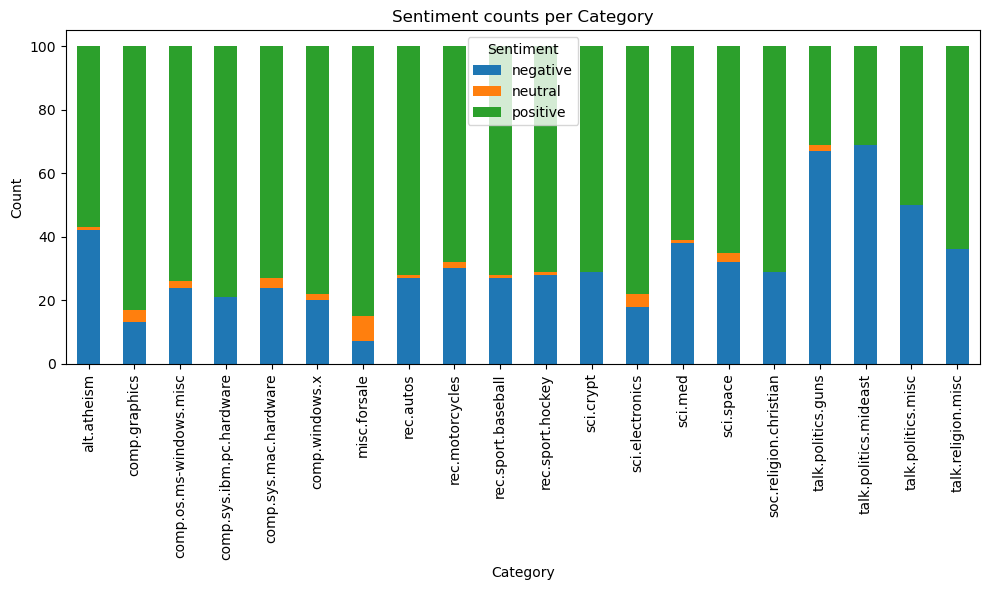

In [30]:
# First, download the required NLTK resource
import nltk
nltk.download('vader_lexicon')

# Now continue with your sentiment analysis code
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# We'll calculate sentiment score for original Data (not cleaned) — as original punctuation, emoticons may help.
def vader_sentiment_label(text, pos_thresh=0.05, neg_thresh=-0.05):
    s = sia.polarity_scores(str(text))
    # compound score: -1 to 1
    c = s['compound']
    if c >= pos_thresh:
        return 'positive'
    elif c <= neg_thresh:
        return 'negative'
    else:
        return 'neutral'

print("\nComputing sentiment labels for each blog post...")
data['sentiment'] = data['Data'].apply(lambda x: vader_sentiment_label(x))

print("\nSentiment distribution overall:")
print(data['sentiment'].value_counts(normalize=False))
print(data['sentiment'].value_counts(normalize=True))

# Sentiment distribution by category
# Fixed variable name from 'df' to 'data' in the crosstab function
sent_by_cat = pd.crosstab(data['Labels'], data['sentiment'], normalize='index')  # proportion within category
print("\nSentiment distribution by category (proportions):")
print(sent_by_cat)

# Plot stacked bar chart of sentiment per category (counts)
plt.figure(figsize=(10,6))
sent_count_by_cat = pd.crosstab(data['Labels'], data['sentiment'])
sent_count_by_cat.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Sentiment counts per Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

In [32]:
# Additional evaluation: How sentiment maps to predicted categories ---
# Merge predictions back to a DataFrame for analysis
test_data = pd.DataFrame({
    'Data': X_test.values,
    'cleaned': X_test.values,
    'true_label': y_test,
    'pred_label': y_pred
})
test_data['true_cat'] = label_encoder.inverse_transform(test_data['true_label'])
test_data['pred_cat'] = label_encoder.inverse_transform(test_data['pred_label'])
# Add sentiment for the test set (recompute using original df mapping)
# We will find the same rows in df since we split by X (text) strings; but safer to recompute:
test_data['sentiment'] = test_data['Data'].apply(lambda x: vader_sentiment_label(x))

print("\nSample of test set (true vs predicted vs sentiment):")
print(test_data[['Data','true_cat','pred_cat','sentiment']].head(10))

# For each category, show accuracy and dominant sentiment
cat_acc = test_data.groupby('true_cat').apply(lambda g: accuracy_score(g['true_label'], g['pred_label']))
cat_sent = pd.crosstab(test_data['true_cat'], test_data['sentiment'], normalize='index')
print("\nPer-category accuracy on test set:")
print(cat_acc)
print("\nPer-category sentiment distribution in test set (proportions):")
print(cat_sent)


Sample of test set (true vs predicted vs sentiment):
                                                   Data  \
1150  newsgroups sci crypt pla sktb demon co uk paul...   
1309  path cantaloupe srv cmu edu da news harvard ed...   
1707  path cantaloupe srv cmu edu magnesium club cc ...   
1524  path cantaloupe srv cmu edu da news harvard ed...   
1645  newsgroups talk politics gun path cantaloupe s...   
1305  path cantaloupe srv cmu edu da news harvard ed...   
534   path cantaloupe srv cmu edu magnesium club cc ...   
842   path cantaloupe srv cmu edu da news harvard ed...   
1714  xref cantaloupe srv cmu edu talk politics mide...   
171   newsgroups comp graphic path cantaloupe srv cm...   

                    true_cat                pred_cat sentiment  
1150               sci.crypt               sci.crypt  positive  
1309                 sci.med                 sci.med  positive  
1707   talk.politics.mideast   talk.politics.mideast  positive  
1524  soc.religion.christian  soc.re

C:\Users\nikhi\AppData\Local\Temp\ipykernel_8716\4008081736.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cat_acc = test_data.groupby('true_cat').apply(lambda g: accuracy_score(g['true_label'], g['pred_label']))
